In [1]:
from pathlib import Path
import numpy as np
import supervision as sv
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb

In [2]:
PATH_MAT = Path("./material")
PATH_IMGS = PATH_MAT / "images"
PATH_TEMPLATE = PATH_MAT / "template" / "pattern.png"

In [3]:
# util para generar color
def str_to_opencv(color: str) -> tuple[int,int,int]:
    rgb = to_rgb(color)
    return tuple(int(255*x) for x in rgb[::-1])

# mostramos para rojo y negro
str_to_opencv('red'), str_to_opencv('black')

((0, 0, 255), (0, 0, 0))

In [4]:
# utils
def plot_boxes(
        boxes: list[tuple[int,int,int,int]] | np.ndarray,
        scores: list[float] | np.ndarray | None,
        base_img: np.ndarray,
        color: tuple[int,int,int] | str = (0,0,255),
        width: int = 2,
        fontScale: float = 0.35,
        fontWidth: int = 1
):
    img_copy = base_img.copy()

    if isinstance(boxes, np.ndarray):
        boxes = boxes.tolist()

    if scores is not None and isinstance(scores,np.ndarray):
        scores = scores.tolist()
    elif scores is None:
        scores = [None] * len(boxes)

    if isinstance(color, str):
        color = str_to_opencv(color)

    for (x1,y1,x2,y2),score in zip(boxes, scores):
        cv.rectangle(img_copy, (x1,y1), (x2,y2), color, width)
        if score is not None:
            label = str(round(score, 3))
            (label_width, label_height), _ = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, fontScale, fontWidth)

            text_end = (x1 + label_width, y1 - label_height)
            cv.rectangle(img_copy, (x1,y1), text_end, (0,0,0),-1)
            cv.putText(img_copy, label, (x1,y1), cv.FONT_HERSHEY_SIMPLEX, fontScale, (255,255,255), fontWidth)
        
    sv.plot_image(img_copy)

In [5]:
IMGS = {p.name[:-4]:p for p in PATH_IMGS.iterdir()}
IMGS

{'COCA-COLA-LOGO': PosixPath('material/images/COCA-COLA-LOGO.jpg'),
 'coca_logo_2': PosixPath('material/images/coca_logo_2.png'),
 'coca_multi': PosixPath('material/images/coca_multi.png'),
 'logo_1': PosixPath('material/images/logo_1.png'),
 'coca_logo_1': PosixPath('material/images/coca_logo_1.png'),
 'coca_retro_2': PosixPath('material/images/coca_retro_2.png'),
 'coca_retro_1': PosixPath('material/images/coca_retro_1.png')}

In [6]:
MIN_BEST_METHODS = {cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED}

In [7]:
DEFAULT_PLOT_PARAMS = dict(
    fontWidth=1, 
    fontScale=0.35, 
    color='blue'
)

In [ ]:
# utils variadas para que multi_detection no quede infinita
EPS = 1e-8

from typing import Iterator

def gaussian_blur(img: np.ndarray, k: int, sigma: float) -> np.ndarray:
    return cv.GaussianBlur(img, (k,k), sigmaX=sigma, sigmaY=sigma)

def scale_iter(
        min_scale: float, 
        max_scale: float, 
        scale_step: float,
        img_shape: tuple[int, int],
        template_shape: tuple[int, int],
        max_aspect_ratio: float,
        aspect_ratio_step: float
    ) -> Iterator[tuple[float,float]]:
    h_ratio, w_ratio = [u/v for u,v in zip(img_shape, template_shape)]

    print('ratios:',tuple(round(i,3) for i in (h_ratio, w_ratio)))

    # can't make it larger than img ratio
    for scaleX in np.arange(min_scale, 
                            min(max_scale, w_ratio)+EPS, 
                            scale_step):
        
        scalesY = scaleX * np.arange(1/max_aspect_ratio, 
                                     max_aspect_ratio+EPS,
                                     aspect_ratio_step)
        # can't make it larger than img ratio
        for scaleY in scalesY[scalesY <= h_ratio]:
            yield scaleX.item(), scaleY.item()

In [118]:
def multi_detection_2step(
    img_rgb: np.ndarray,
    template: np.ndarray,
    threshold: float = 0,
    top_perc: float = 0.1,
    method: int = cv.TM_CCOEFF_NORMED,
    max_img_ratio: float = 4.0,
    nms_max_overlap: float = 0.4,
    scale_range: tuple[float, float] = (0.2, 2),
    scale_step: float = 0.1,
    max_aspect_ratio: float = 1.5,
    aspect_ratio_step: float = 0.1,
    canny_thresholds: tuple[int,int] = (100, 200),
    blur_template_k_sigma: tuple[int, float] | None = (3,0.5),
    blur_img_k_sigma: tuple[int, float] | None = (3,0.5),
    debug: bool = False,
    plot: bool = False,
    plot_params: dict = DEFAULT_PLOT_PARAMS
) -> tuple[list[tuple[int, int, int, int]], list[float]]:
    
    # grayscale both
    img_gs = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
    template = cv.cvtColor(template, cv.COLOR_BGR2GRAY)

    # CLAHE
    #clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #img_gs = clahe.apply(img_gs)
    
    # TODO: scale image
    # max_ratio = max(u/v for u,v in zip(img_gs.shape, template.shape))
    # downscale_img = max_ratio > max_img_ratio
    # if downscale_img:
    #   img_gs = cv.resize o algo así, con scale=1/max_ratio
    # TODO: ver si es mejor resizear sobre BGR o grayscale
    print("TODO: scale image if it's too large")

    # blur img if specified
    if blur_img_k_sigma is not None:
        img_gs = gaussian_blur(img_gs, *blur_img_k_sigma)

    # canny on img
    img_edges = cv.Canny(img_gs, *canny_thresholds)

    # util: process one
    def process_one(scaleX: float, scaleY: float, min_confidence: float | None = None):
        # resize template
        scaled_template = cv.resize(
            template, None, 
            fx=scaleX, fy=scaleY, 
            interpolation=cv.INTER_LINEAR
        ) # type: ignore

        # double check
        h, w = scaled_template.shape
        if img_edges.shape[0] < h or img_edges.shape[1] < w:
            if debug:
                print(f"Scale {scaleX}, {scaleY} out of base image bounds")
            return -1
        
        # blur template if specified
        if blur_template_k_sigma is not None:
            scaled_template = gaussian_blur(scaled_template, *blur_template_k_sigma)
        
        # canny on resized template
        template_edges = cv.Canny(scaled_template, *canny_thresholds)

        # template matching
        result = cv.matchTemplate(img_edges, template_edges, method)

        # if minimizing, mirror x axis
        confidences = (1.0 - result) if method in MIN_BEST_METHODS else result

        # no min_confidence <=> we're looking for it <=> round 1
        if min_confidence is None:
            return confidences.max()
        
        # round 2: return indices + confidence scores, given by min_confidence
        # get indices + confidence scores
        mask = confidences >= min_confidence
        match_indices = np.where(mask)
        confidences = confidences[mask]

        if debug:
            print(f"{[round(x,3) for x in (scaleX,scaleY)]}-pre-NMS:{len(match_indices[0])}")

        # double check
        assert len(confidences)>0, f"{(scaleX,scaleY)} in round 2 should have detections"

        return [(x, y, x+w, y+h) for y,x in zip(*match_indices)], confidences.tolist()
            
    # ROUND 1
    # get max for each scale
    scales_max_conf = [
        (scales, process_one(*scales, None))
        for scales in scale_iter(*scale_range, scale_step, 
                                 img_gs.shape, template.shape,
                                 max_aspect_ratio, aspect_ratio_step)
    ]
    max_conf: float = max(b for a,b in scales_max_conf) # type: ignore

    if debug:
        print("Max conf found is", max_conf)
    
    # min_confidence must be within top_perc of max_conf and also >= threshold
    min_confidence = max(max_conf*(1-top_perc), threshold)

    if debug:
        print("Min confidence is:", min_confidence)

    # ROUND 2
    # get detections
    boxes = []
    scores = []
    for scales, conf in scales_max_conf:
        if conf < min_confidence:
            continue
    
        b,c = process_one(*scales, min_confidence)

        boxes.extend(b)
        scores.extend(c)
        #print("ASD",len(c),c[0])

    # now build detections, apply NMS
    if not boxes:
        if debug:
            print("No detections found, best was",max_conf)
        return [], []

    detections = sv.Detections( 
        xyxy=np.array(boxes),
        confidence=np.array(scores)
    )
    detections = detections.with_nms(threshold=nms_max_overlap, class_agnostic=True)
    xyxy = detections.xyxy.tolist()
    confidences = detections.confidence.tolist()

    # TODO: if needed, up-project boxes
    # if downscale_img:
    # algo acá

    if plot:
        plot_boxes(xyxy, confidences, img_rgb, **plot_params)
    
    return xyxy, confidences

(175, 400, 3)


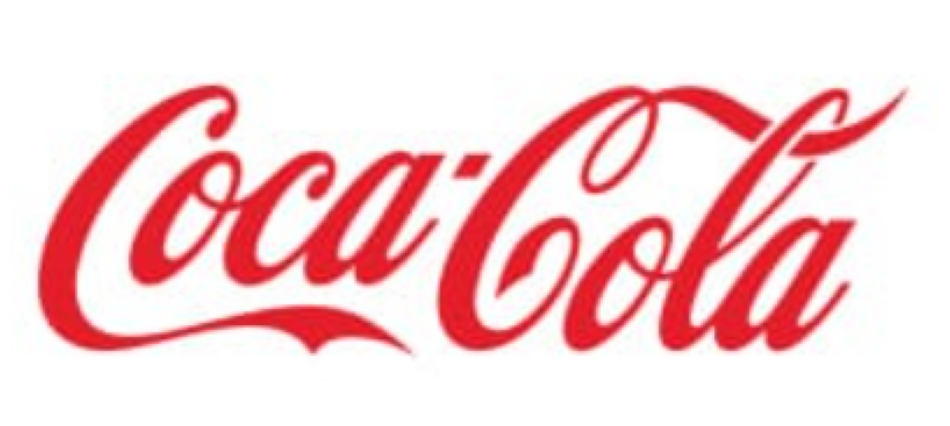

In [59]:
# levantamos el template
TEMPLATE = cv.imread(PATH_TEMPLATE)

print(TEMPLATE.shape)

sv.plot_image(TEMPLATE)

In [49]:
for name, p in IMGS.items():
    img = cv.imread(p)
    print(f"{name:>15}\t{img.shape}\t",
          tuple(round(u/v, 4) for u,v in zip(img.shape, TEMPLATE.shape))[:2]
    )

 COCA-COLA-LOGO	(1389, 1389, 3)	 (7.9371, 3.4725)
    coca_logo_2	(363, 233, 3)	 (2.0743, 0.5825)
     coca_multi	(598, 799, 3)	 (3.4171, 1.9975)
         logo_1	(450, 687, 3)	 (2.5714, 1.7175)
    coca_logo_1	(500, 207, 3)	 (2.8571, 0.5175)
   coca_retro_2	(429, 715, 3)	 (2.4514, 1.7875)
   coca_retro_1	(493, 715, 3)	 (2.8171, 1.7875)


TODO: scale image if it's too large
ratios: (2.817, 1.788)
Max conf found is 0.07483483
Min confidence is: 0.06735135
[1.3, 0.929]-pre-NMS:1
[1.3, 1.319]-pre-NMS:6


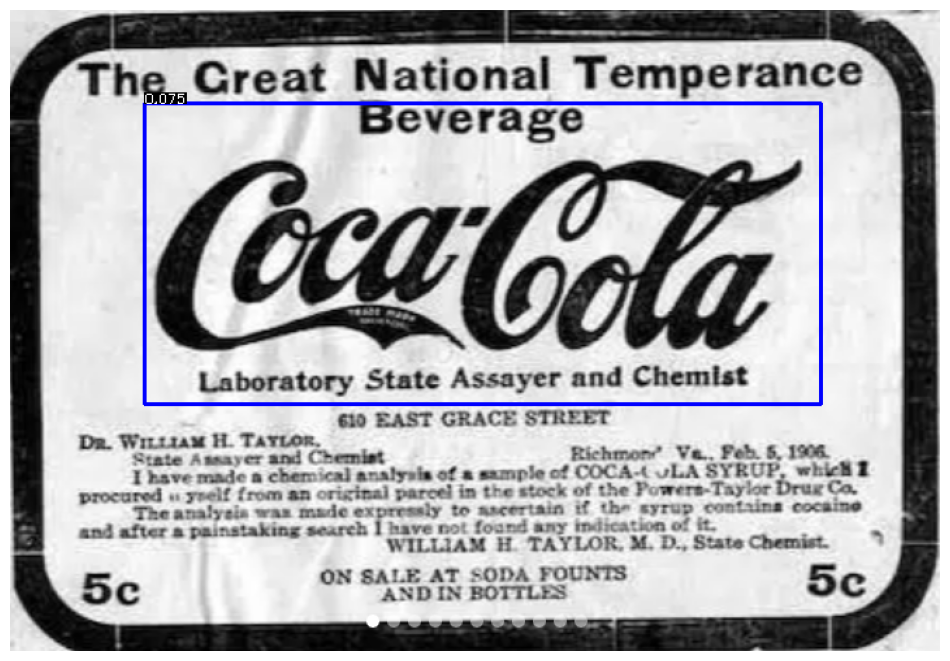

In [176]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_retro_1']),
    TEMPLATE,
    scale_range=(1,2),
    max_aspect_ratio=1.4,
    debug=True,
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (2.451, 1.788)
Max conf found is 0.31304488
Min confidence is: 0.28174037
[0.4, 0.387]-pre-NMS:2


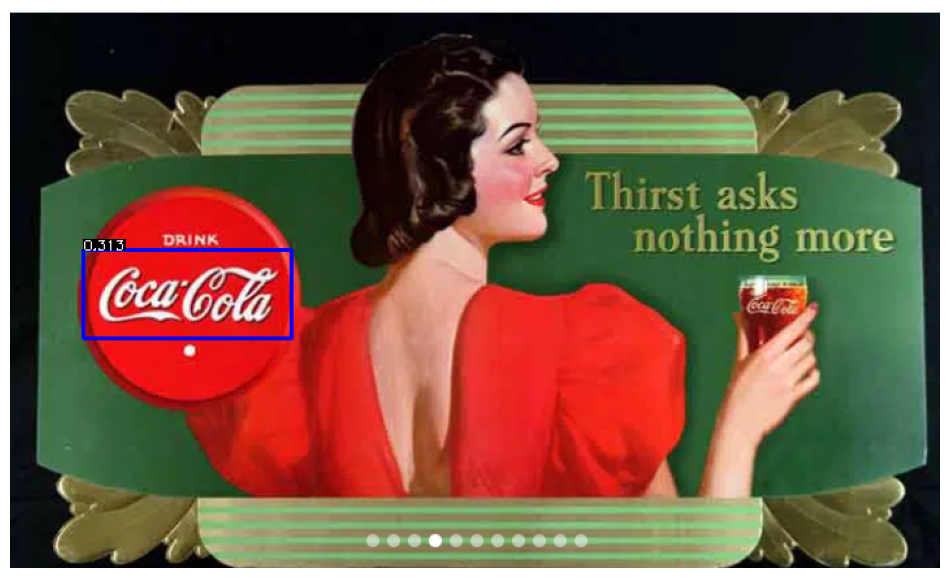

In [178]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_retro_2']),
    TEMPLATE,
    debug=True,
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (3.417, 1.998)
Max conf found is 0.26037112
Min confidence is: 0.18225978
[0.21, 0.161]-pre-NMS:1
[0.21, 0.182]-pre-NMS:1
[0.21, 0.203]-pre-NMS:4
[0.21, 0.224]-pre-NMS:10
[0.21, 0.245]-pre-NMS:50
[0.21, 0.266]-pre-NMS:39
[0.21, 0.287]-pre-NMS:10
[0.21, 0.308]-pre-NMS:5


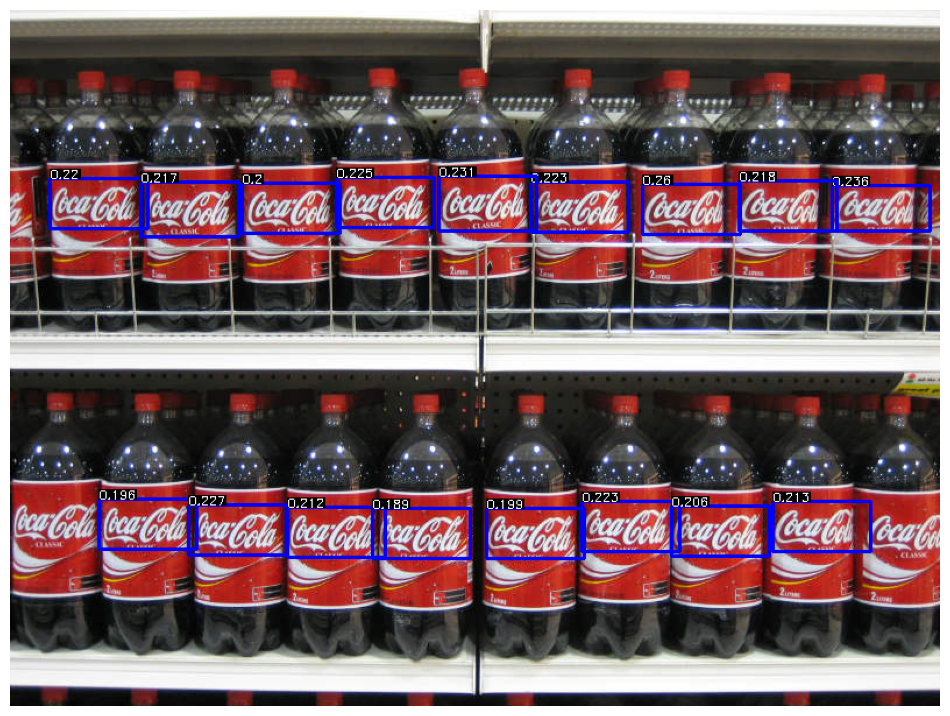

In [221]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_multi']),
    TEMPLATE,
    top_perc=0.3,
    scale_range=(0.21,10),
    debug=True,
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (3.417, 1.998)
Max conf found is 0.43033388
Min confidence is: 0.35287377
[0.2, 0.133]-pre-NMS:9
[0.2, 0.153]-pre-NMS:8
[0.2, 0.173]-pre-NMS:16
[0.2, 0.193]-pre-NMS:10
[0.2, 0.213]-pre-NMS:32
[0.2, 0.233]-pre-NMS:42
[0.2, 0.253]-pre-NMS:67
[0.2, 0.273]-pre-NMS:21
[0.2, 0.293]-pre-NMS:4


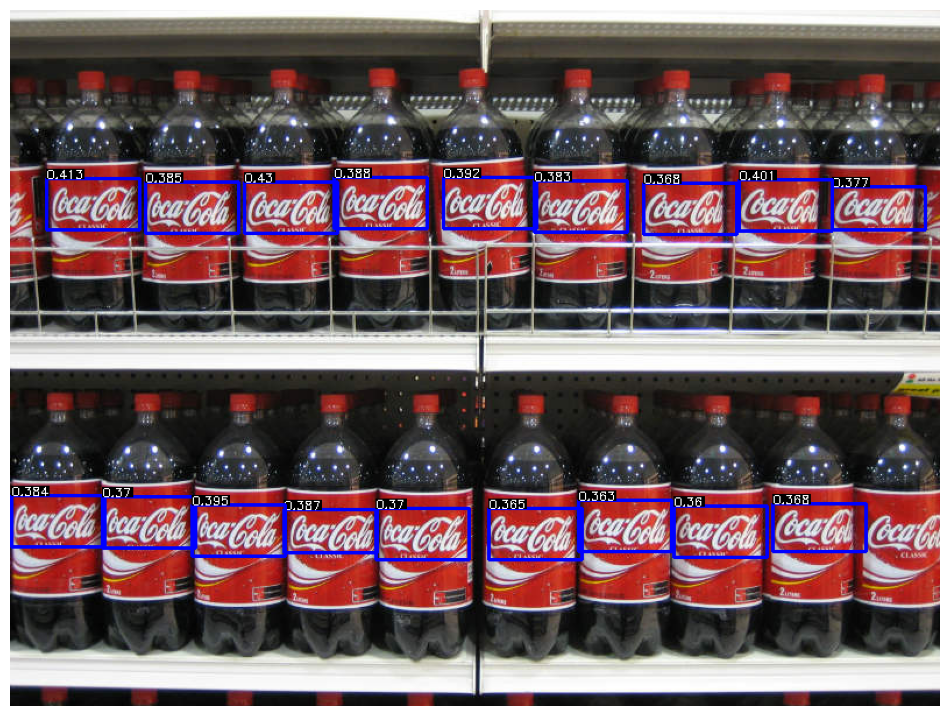

In [ ]:
# sin embargo utilizando CCORR_NORMED...
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_multi']),
    TEMPLATE,
    top_perc=0.18,
    method=cv.TM_CCORR_NORMED,
    debug=True,
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (2.857, 0.517)


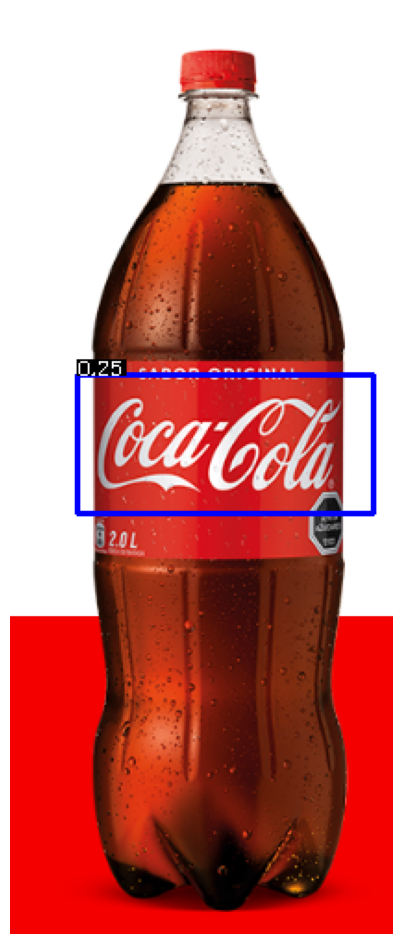

In [180]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_logo_1']),
    TEMPLATE,
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (2.074, 0.583)


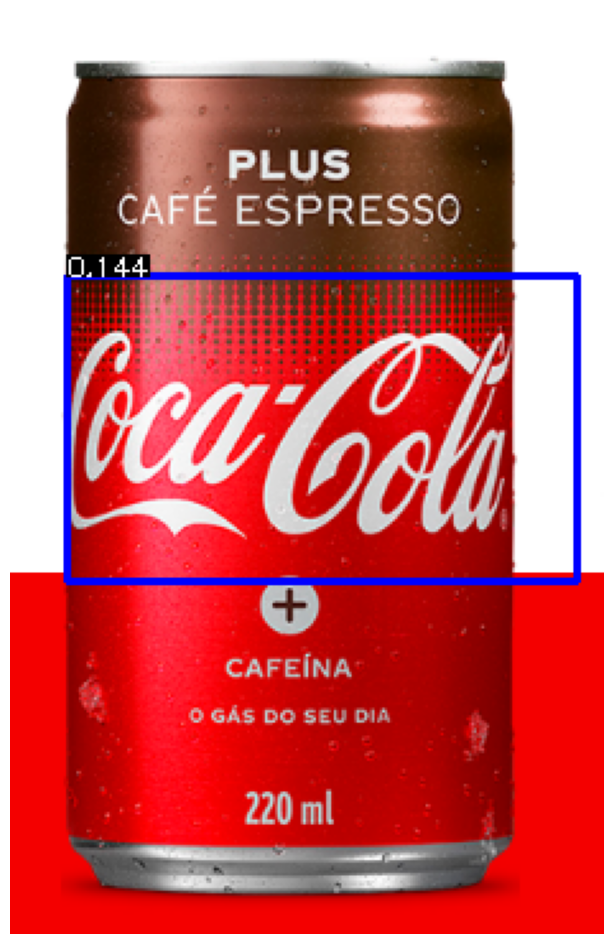

In [183]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['coca_logo_2']),
    TEMPLATE,
    scale_range=(0.5,2),
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (2.571, 1.718)


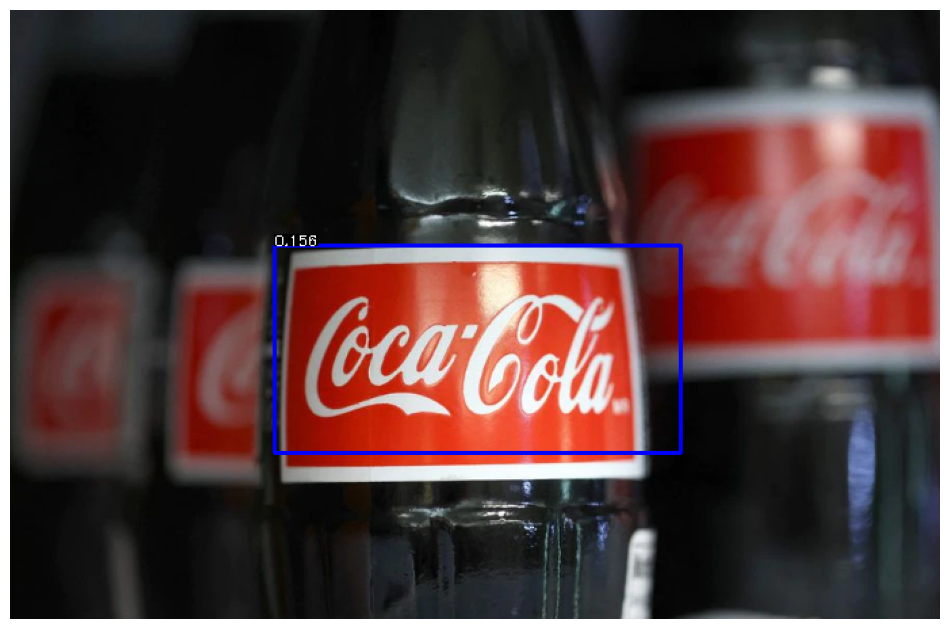

In [184]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['logo_1']),
    TEMPLATE,
    scale_range=(0.75,2),
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

TODO: scale image if it's too large
ratios: (7.937, 3.473)


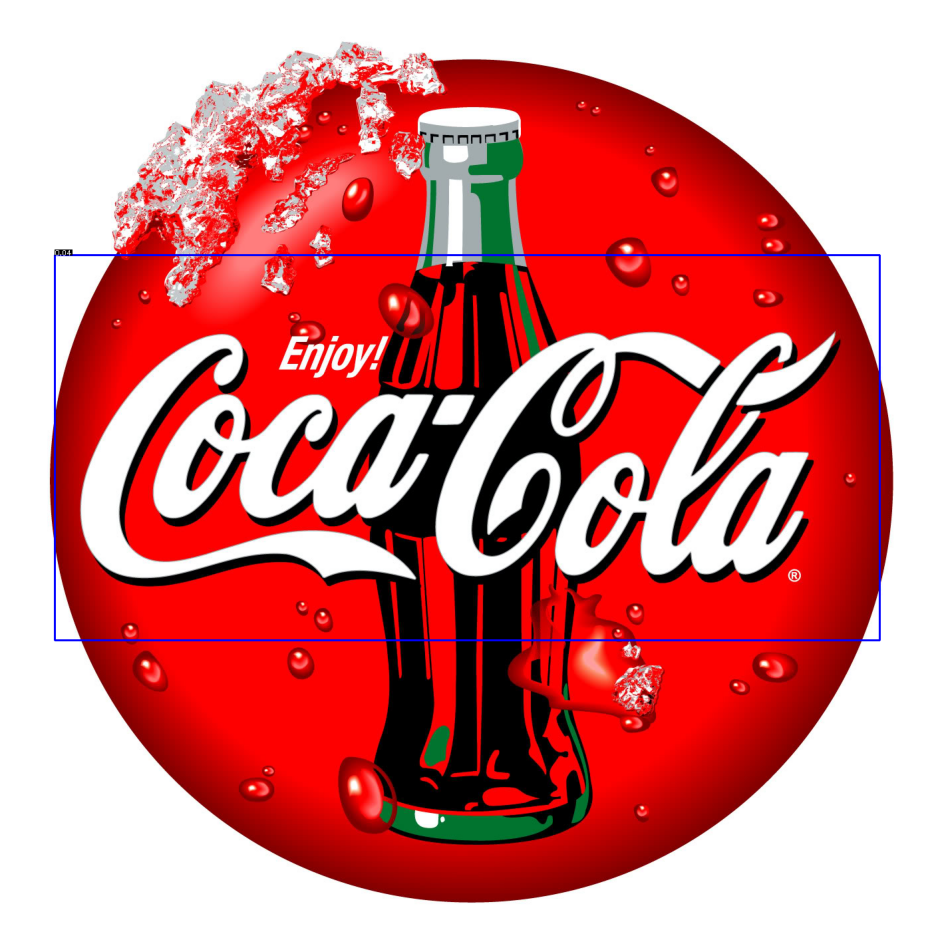

In [185]:
dets, scores = multi_detection_2step(
    cv.imread(IMGS['COCA-COLA-LOGO']),
    TEMPLATE,
    scale_range=(3,10),
    plot=True,
    blur_img_k_sigma=None,
    blur_template_k_sigma=None,
)

* Es imposible lograr resultados correctos con los mismos exactos parámetros para cada uno
* Bajo esta nueva lógica se logró una heurística suficientemente compleja como para cubrir todos los casos casi sin cambios en los parámetros
* Se probó sin utilizar Gaussian Blur y el resultado fue el mismo, por lo que se descarta para la solución final
* No hizo falta escalar la imagen original para poder hacer detecciones sobre la imagen más grande, siempre y cuando se ajustara correctamente la escala mínima a la que trabajar (una mucho más grande que la estandar)